In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from julia_venv import get_julia
from diffeqpy import de
import theano
import theano.tensor as tt
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import seaborn as sns

ModuleNotFoundError: No module named 'julia_venv'

ModuleNotFoundError: No module named 'julia_venv'

In [3]:
jul = get_julia()

RuntimeError: It seems your Julia and PyJulia setup are not supported.

Julia interpreter:
    julia
Python interpreter and libpython used by PyCall.jl:
    /home/junpenglao/anaconda3/bin/python3
    /home/junpenglao/anaconda3/lib/libpython3.6m.so.1.0
Python interpreter used to import PyJulia and its libpython.
    /home/junpenglao/anaconda3/bin/python
    /home/junpenglao/anaconda3/lib/libpython3.6m.so.1.0

Your Python interpreter "/home/junpenglao/anaconda3/bin/python"
is statically linked to libpython.  Currently, PyJulia does not support
such Python interpreter.  One easy workaround is to run your Python
script with `python-jl` command bundled in PyJulia.  You can simply do:

    python-jl PATH/TO/YOUR/SCRIPT.py

See `python-jl --help` for more information.

For other available workarounds, see:
    https://github.com/JuliaPy/pyjulia/issues/185

For more information, see:
    https://github.com/JuliaPy/pyjulia
    https://github.com/JuliaPy/PyCall.jl


In [3]:
class ODE(theano.Op):
    def __init__(self, dy_function, start, eval_points, n_params, solver, *args):
        super().__init__(*args)
        if not isinstance(eval_points, np.ndarray):
            raise TypeError('eval_points must be a numpy array.')
        if not isinstance(start, np.ndarray):
            raise TypeError('start must be a numpy array.')
            
        self._dy_function = dy_function
        self._start = start
        self._eval_points = eval_points
        self._n_params = n_params
        self._t_range = (0., float(np.max(eval_points)))
        self._solver = solver

    def make_node(self, params):
        if not params.ndim == 1:
            raise ValueError('Parameter array must be 1d')

        params = theano.tensor.as_tensor_variable(params)
        out_type = tt.TensorType(self._eval_points.dtype, [False, False])
        out = tt.TensorVariable(out_type)
        grad_type = tt.TensorType(
            params.dtype,
            [False, False, False])
        grad = tt.TensorVariable(grad_type)
        return theano.Apply(self, [params], [out, grad])

    def perform(self, node, inputs, output_storage):
        problem = de.ODELocalSensitivityProblem(
            self._dy_function, self._start, self._t_range, inputs[0])
        solution = de.solve(problem, self._solver, saveat=self._eval_points)
        if solution.retcode != 'Success':
            n_time = len(self._eval_points)
            n_sol = len(self._start)
            output_storage[0][0] = np.full((n_time, n_sol), np.nan)
            output_storage[1][0] = np.full((n_time, self._n_params, n_sol), np.nan)
            return
        
        vals = []
        grads = []
        if self._eval_points[0] == 0:
            start_idx = 0
        else:
            start_idx = 1
        for i in range(start_idx, len(solution.t)):
            # julia indexing is 1-based
            val, grad = de.extract_local_sensitivities(solution, i + 1)
            vals.append(val)
            grads.append(grad)

        output_storage[0][0] = np.array(vals)
        output_storage[1][0] = np.array(grads)
        
    def grad(self, inputs, g):
        val, grad = self(*inputs)
        return [(grad * g[0][:, None, :]).sum(0).sum(-1)]


In [29]:
func = jul.eval("""
@ode_def_nohes simple begin
    dx1 = v1
    dx2 = v2
    dv1 = -M1 * x1 / (x1 ^ 2 + x2 ^ 2)^(3/2) - M2 * (x1 - 1) / ((x1 - 1) ^ 2 + (x2 - 0.5) ^ 2)^(3/2)
    dv2 = -M1 * x2 / (x1 ^ 2 + x2 ^ 2)^(3/2) - M2 * (x2 - 0.5) / ((x1 - 1) ^ 2 + (x2 - 0.5) ^ 2)^(3/2)
end M1 M2
""")

In [41]:
u0 = np.array([0.3, 0.2, 20, 0.0])
tmax = 0.2
problem = de.ODEProblem(func, u0, (0., tmax), [1., 0.1])
solution = de.solve(problem)

In [59]:
u0 = np.array([0.3, 0.2, 1.6, -0.3])
tmax = 1.
problem = de.ODEProblem(func, u0, (0., tmax), [1., 0.1])
solution = de.solve(problem)

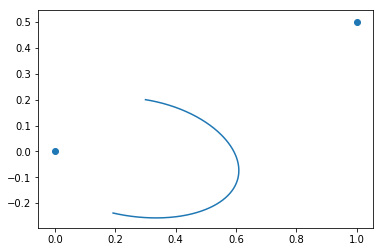

In [60]:
vals = np.linspace(0, tmax, 400)
y = [solution(t) for t in vals]
plt.plot(*np.array(y)[:, :2].T)
plt.scatter(*np.array([[0, 0], [1, 0.5]]).T)

In [61]:
observation_times = np.array([0.2, 0.3, 0.4, 0.5, .6, .8, .9, .95])
true_state = np.array([solution(t) for t in observation_times])
true_pos = true_state[:, :2]
sigma = 0.01
measured_pos = true_pos + sigma * np.random.randn(*true_pos.shape)

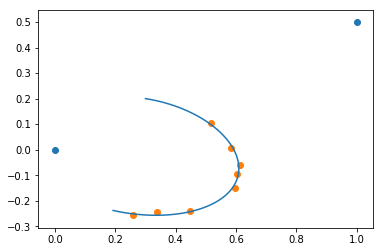

In [62]:
plt.plot(*np.array(y)[:, :2].T)
plt.scatter(*np.array([[0, 0], [1, 0.5]]).T)
plt.scatter(*measured_pos.T)

In [63]:
with pm.Model() as model:
    log_m1 = pm.Normal('log_m1', mu=0.03, sd=0.05)
    m1 = tt.exp(log_m1)
    pm.Deterministic('m1', m1)
    log_m2 = pm.Normal('log_m2', mu=-2.3, sd=0.1)
    m2 = tt.exp(log_m2)
    pm.Deterministic('m2', m2)
    
    sigma = pm.HalfNormal('sigma', 0.015)
    
    solver = ODE(func, u0, observation_times, 2, de.Vern7())
    position = solver(tt.stack([m1, m2]))[0]
    position = position[:, :2]
    pm.Deterministic('position', position)
    
    pm.Normal('y', mu=position, sd=sigma, observed=measured_pos)

In [64]:
# In order to use the adjoined derivatives, we probably want
# something like this (but with a better interface?)

# error_dist = pm.Normal.dist(sd=tt.stack([sigma_x, sigma_y]))
# pm.ODEObservedTimes(
#     'y', error_dist, func, u0, observation_times, observed=observed)

In [65]:
func = model.logp_dlogp_function(profile=True)
func.set_extra_values({})
x = np.random.randn(func.size) * 0.001
for _ in range(100):
    func(x)

In [66]:
%timeit func(x)

3.84 ms ± 204 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [67]:
func.profile.summary_ops(N=10)

Ops
---
<% time> <sum %> <apply time> <time per call> <type> <#call> <#apply> <Op name>
  97.8%    97.8%       3.320s       3.64e-03s     Py     911        1   <__main__.ODE object at 0x1c3d28d080>
   0.4%    98.3%       0.015s       1.67e-05s     C      911        1   IncSubtensor{InplaceInc;::, :int64:}
   0.3%    98.6%       0.010s       3.48e-06s     C     2733        3   IncSubtensor{InplaceInc;int64:int64:}
   0.1%    98.7%       0.005s       1.73e-06s     C     2733        3   Alloc
   0.1%    98.8%       0.003s       1.70e-06s     C     1822        2   InplaceDimShuffle{x,x}
   0.1%    98.9%       0.003s       7.06e-07s     C     3644        4   Sum{acc_dtype=float64}
   0.1%    99.0%       0.002s       2.46e-06s     C      911        1   Elemwise{Composite{Switch(i0, (i1 * (i2 - i3)), i4)}}
   0.1%    99.0%       0.002s       2.24e-06s     C      911        1   Elemwise{Composite{(Switch(i0, (i1 * i2 * i2), i3) + i4 + (i5 * (((i6 * i7 * Composite{inv(Composite{(sqr(i0) * i0)}(

In [68]:
with model:
    pred = pm.sample_prior_predictive()

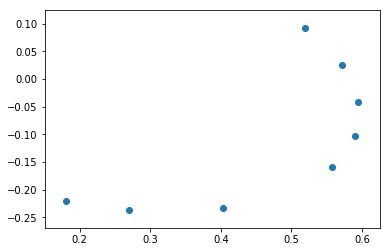

In [73]:
plt.scatter(*pred['position'][3].T)

We sample with only one core, appearently multiprocessing and julia don't work well together.
The second chain doesn't sample at all if we use multiprocessing.

In [74]:
with model:
    trace = pm.sample(init='adapt_diag', cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, log_m2, log_m1]
100%|██████████| 1000/1000 [00:43<00:00, 23.04it/s]


In [83]:
pm.effective_n(trace)

{'log_m1': 481.9726224735199,
 'log_m2': 518.0924009408575,
 'm1': 481.73164477805744,
 'm2': 512.073154197797,
 'sigma': 545.8739602666244,
 'position': array([[1265.7010564 , 1486.96550494],
        [1403.06528137, 1213.05975095],
        [1471.58087939,  845.4809863 ],
        [1498.61923827,  692.43098576],
        [1503.94635357,  613.69006663],
        [1464.15173887,  513.49461506],
        [1400.41515961,  465.13481349],
        [1346.10887717,  460.34378396]])}

In [84]:
pm.gelman_rubin(trace)

{'log_m1': 1.0006891945650531,
 'log_m2': 1.0008083832664203,
 'm1': 1.0006960358126993,
 'm2': 1.000738854774232,
 'sigma': 0.9995779890500335,
 'position': array([[0.99921639, 0.99903087],
        [0.99909221, 0.99923421],
        [0.99904202, 0.99972368],
        [0.99902477, 1.00007193],
        [0.99902193, 1.00031523],
        [0.99905032, 1.00072773],
        [0.99910208, 1.00090424],
        [0.99915233, 1.00089082]])}

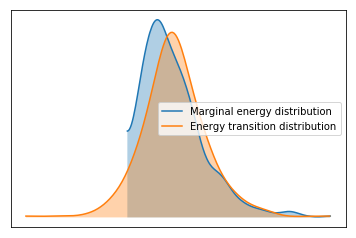

In [85]:
pm.energyplot(trace)

We learn a lot about the mass of the first point.

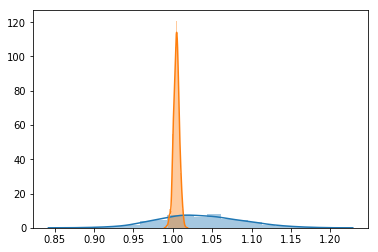

In [75]:
sns.distplot(pred['m1'])
sns.distplot(trace['m1'])

The marginal uncertainty in the mass of the second point doesn't change much.

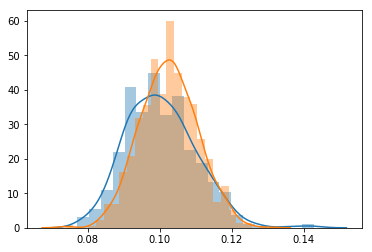

In [76]:
sns.distplot(pred['m2'])
sns.distplot(trace['m2'])

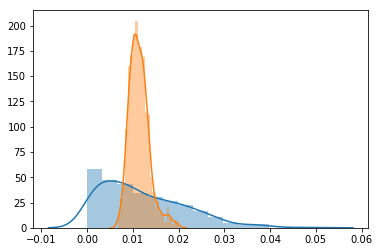

In [77]:
sns.distplot(pred['sigma'])
sns.distplot(trace['sigma'])

The posteriors are correlated. So after observing the value we know that if M1 is small, then so is M2.

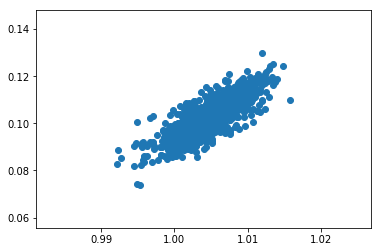

In [87]:
plt.scatter(trace['m1'], trace['m2'])